In [4]:
from pydantic import BaseModel
import torch
import numpy as np
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Function to load the entire dataset from a CSV file and create a DataLoader
def load_dataloader_from_csv(csv_file, batch_size=128, img_shape=(1, 32, 32)):
    df = pd.read_csv(csv_file)

    # Separate the features (image data) and labels
    labels = df['label'].values
    features = df.drop(columns=['label']).values

    # Reshape the features back into the original image shape
    features = features.reshape(-1, *img_shape)

    # Convert to PyTorch tensors
    data_tensors = torch.tensor(features, dtype=torch.float32)
    label_tensors = torch.tensor(labels, dtype=torch.long)

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(data_tensors, label_tensors)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return data_loader

In [6]:
DATA_PATH = '../dataset/'

train_loader = load_dataloader_from_csv(f"{DATA_PATH}train.csv", batch_size=128)
val_loader = load_dataloader_from_csv(f"{DATA_PATH}val.csv", batch_size=128)
test_loader = load_dataloader_from_csv(f"{DATA_PATH}test.csv", batch_size=128)

# Example: Iterate over the train_loader
for batch_idx, (data, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


Batch 1:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 2:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 3:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 4:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 5:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 6:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 7:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 8:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 9:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 10:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 11:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 12:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
B

In [7]:
NUM_CLASSES = 29
LABELS = [chr(i) for i in range(65, 91)] + ["SPACE", "DELETE", "NOTHING"]

class ConvNet(nn.Module):
    def __init__(self, num_classes=29):
        super(ConvNet, self).__init__()
        
        # 1st convolution layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 2nd convolution layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 3rd convolution layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model_path = "asl_model.pth"

model = ConvNet(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path))

C:\Users\amine\AppData\Local\Temp\ipykernel_38552\3242582271.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Predicted Label: 7


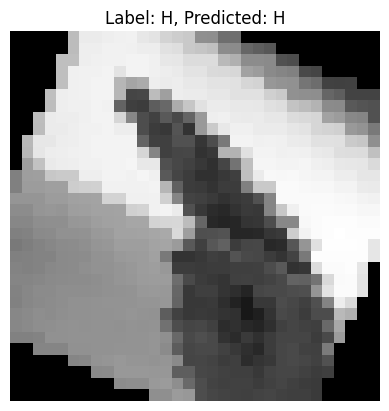

Predicted Label: 22


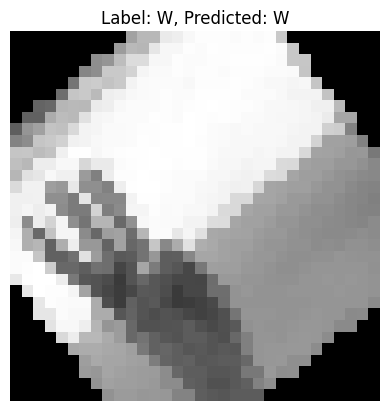

Predicted Label: 7


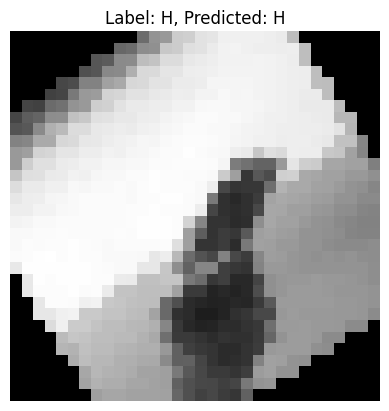

Predicted Label: 23


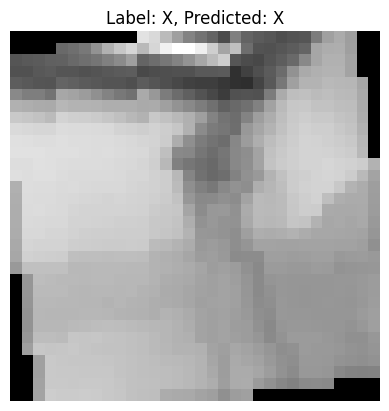

Predicted Label: 17


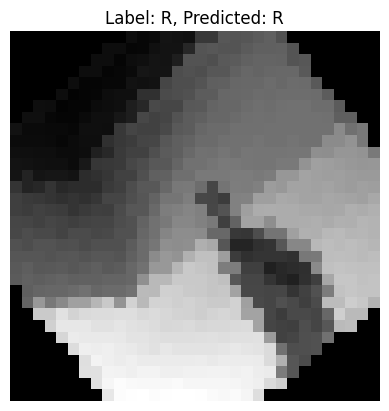

Predicted Label: 10


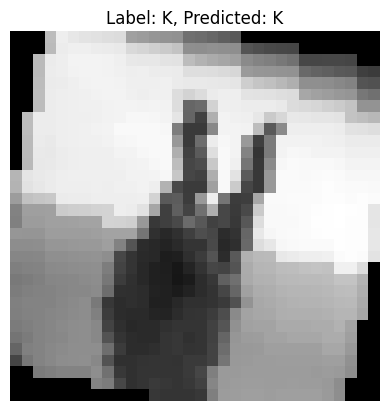

Predicted Label: 22


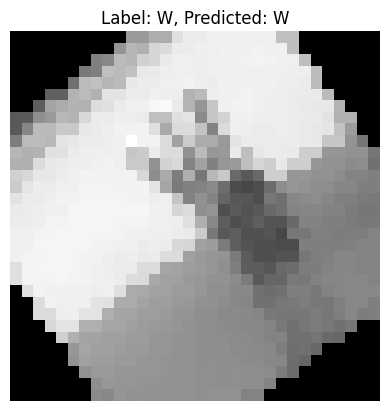

Predicted Label: 0


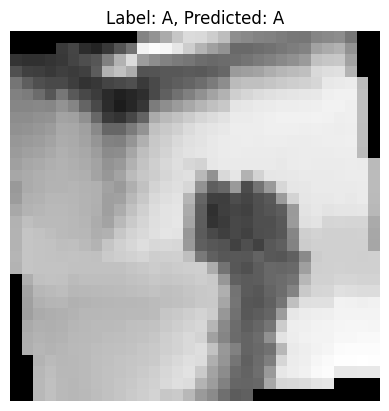

Predicted Label: 27


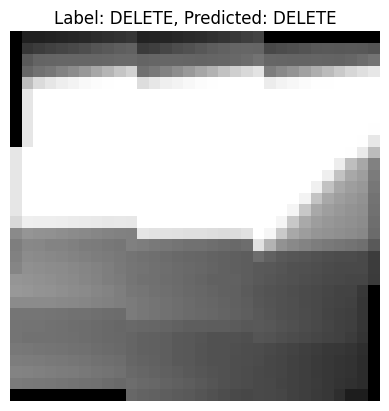

Predicted Label: 6


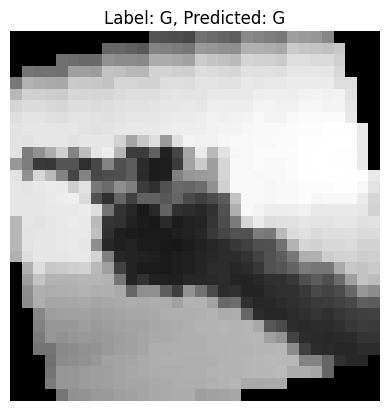

In [24]:
import matplotlib.pyplot as plt
import torch
import numpy as np

LABELS = [chr(i) for i in range(65, 91)] + ["SPACE", "DELETE", "NOTHING"]

# Example: Visualize an image from the train_loader
for batch_idx, (data, labels) in enumerate(train_loader):
    model.eval()  # Set the model to evaluation mode
    
    indices = range(10) #[2]  # Change this to any indices you want
    for i in indices:
        with torch.no_grad():
            inputs = data[i].unsqueeze(0)  # Add batch dimension at position 0
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted label
            predicted_label = predicted.item()
            print("Predicted Label:", predicted_label)

        # Prepare the image for display
        image = data[i].numpy().squeeze()  # Convert to numpy and remove channel dimension
        label = labels[i].item()  # Convert label to a scalar value

        # Plot the image with both the label and the prediction
        plt.imshow(image, cmap="gray")  # Display in grayscale
        plt.title(f"Label: {LABELS[label]}, Predicted: {LABELS[predicted_label]}")
        plt.axis("off")
        plt.show()

    break  # Display only the first batch


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `true_labels` and `predicted_labels` are your ground truth and model predictions
true_labels = []
predicted_labels = []

# Collect true and predicted labels for evaluation
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()